## Resources
https://towardsdatascience.com/chunking-in-nlp-decoded-b4a71b2b4e24

In [2]:
from codecarbon import EmissionsTracker
import Config as CON
import os
import sys
import random
import json
import time
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import string

import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

total_tracking_list = []   #made this so that we could possibly plot a graph afterwards 

total_tracker = 0
tracker = EmissionsTracker()
tracker.start()

wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

#Declare some necessary global functions and objects
current_time_ms = lambda: int(round(time.time() * 1000))

emissions = tracker.stop()
print("emissions for this cell: ", emissions)
total_tracker += emissions 
print("Total_tracker so far: ", total_tracker)
total_tracking_list.append(total_tracker)
print("total_tracking_list: ", total_tracking_list)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
/Users/saiful/opt/anaconda3/envs/msi/lib/python3.8/site-packages/apscheduler/util.py:95: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  if obj.zone == 'local':
/Users/saiful/opt/anaconda3/envs/msi/lib/python3.8/site-packages/apscheduler/triggers/interval.py:66: PytzUsageWarning: The normalize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return self.timezone.normalize(next_fire_time)


emissions for this cell:  7.319580509190498e-09
Total_tracker so far:  7.319580509190498e-09
total_tracking_list:  [7.319580509190498e-09]


## Read keyword frequency and identify top keywords (candidate entities)

In [3]:
tracker = EmissionsTracker()
tracker.start()

keyword_filename = os.path.join(CON.OUTPUT_DATA_DIRECTORY,"keyword_frequency.txt")
assert(os.path.exists(keyword_filename))

with open(keyword_filename, encoding='utf-8') as f:
    keyword_frequency = json.loads(f.read())
    
emissions = tracker.stop()
print("emissions for this cell: ", emissions)
total_tracker += emissions 
print("Total_tracker so far: ", total_tracker)
total_tracking_list.append(total_tracker)
print("total_tracking_list: ", total_tracking_list)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.


emissions for this cell:  4.488347448407035e-07
Total_tracker so far:  4.5615432534989405e-07
total_tracking_list:  [7.319580509190498e-09, 4.5615432534989405e-07]


CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.


4760
emissions for this cell:  3.206009508185006e-07
Total_tracker so far:  7.767552761683947e-07
total_tracking_list:  [7.319580509190498e-09, 4.5615432534989405e-07, 7.767552761683947e-07]


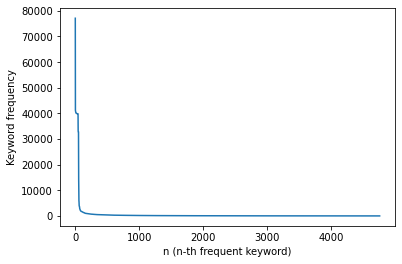

In [4]:
tracker = EmissionsTracker()
tracker.start()


#keyword_frequency[x] = how many times keyword x appeared in the corpus
i = 0
sum_frequency = 0
freq_list = []

for key in keyword_frequency.keys():
    i +=1
    f = keyword_frequency[key]
    freq_list.append(f)
    sum_frequency += f

top_keywords = []
cumulated_frequency = 0
for key in keyword_frequency.keys():
    f = keyword_frequency[key]
    cumulated_frequency += f
    top_keywords.append(key)
    #We consider the top keywords that cover 80% of total keyword appearances -> set it to 0.6 (60%) for a quick run
    if cumulated_frequency>(0.8*sum_frequency):
        break

print(len(top_keywords)) #we are considering top 4760 keywords as possible entities
plt.plot(np.arange(0,len(top_keywords)),freq_list[0:len(top_keywords)]); #Show frequency distribution of top keywords
plt.xlabel('n (n-th frequent keyword)')
plt.ylabel('Keyword frequency')

#Write top keywords to a file
with open('top_keywords.txt', 'w') as f:
    for item in top_keywords:
        f.write("%s\n" % item)
        
emissions = tracker.stop()
print("emissions for this cell: ", emissions)
total_tracker += emissions 
print("Total_tracker so far: ", total_tracker)
total_tracking_list.append(total_tracker)
print("total_tracking_list: ", total_tracking_list)

## Process an abstract and generate named entities

### Using keyword-detection (not performing well)

### Using Spacy NER Pipeline (not performing well)

## Using NLTK Phrase chunking (Looks promising)

### Uncomment these when running for the first time

In [4]:
#!pip install nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('conll2000')

In [6]:
from nltk.corpus import conll2000
from nltk.chunk.util import tree2conlltags,conlltags2tree
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

tracker = EmissionsTracker()
tracker.start()

data= conll2000.chunked_sents()
train_data=data[:10900]
test_data=data[10900:]

def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]

def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

#Define the chunker class
class NGramTagChunker(ChunkParserI):
    def __init__(self,train_sentences,tagger_classes=[UnigramTagger,BigramTagger]):
        train_sent_tags=conll_tag_chunks(train_sentences)
        self.chunk_tagger=combined_tagger(train_sent_tags,tagger_classes)
        
    def parse(self,tagged_sentence):
        if not tagged_sentence:
            return None
        pos_tags=[tag for word, tag in tagged_sentence]
        chunk_pos_tags=self.chunk_tagger.tag(pos_tags)
        chunk_tags=[chunk_tag for (pos_tag,chunk_tag) in chunk_pos_tags]
        wpc_tags=[(word,pos_tag,chunk_tag) for ((word,pos_tag),chunk_tag) in zip(tagged_sentence,chunk_tags)]
        return conlltags2tree(wpc_tags)

#train chunker model
ntc=NGramTagChunker(train_data)
#evaluate chunker model performance
print(ntc.evaluate(test_data))

emissions = tracker.stop()
print("emissions for this cell: ", emissions)
total_tracker += emissions 
print("Total_tracker so far: ", total_tracker)
total_tracking_list.append(total_tracker)
print("total_tracking_list: ", total_tracking_list)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
/Users/saiful/opt/anaconda3/envs/msi/lib/python3.8/site-packages/apscheduler/util.py:95: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  if obj.zone == 'local':
/Users/saiful/opt/anaconda3/envs/msi/lib/python3.8/site-packages/apscheduler/triggers/interval.py:66: PytzUsageWarning: The normalize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return self.timezone.normalize(next_fire_time)


ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%
emissions for this cell:  3.552257531441528e-06
Total_tracker so far:  4.329012807609923e-06
total_tracking_list:  [7.319580509190498e-09, 4.5615432534989405e-07, 7.767552761683947e-07, 4.329012807609923e-06]


In [7]:
def print_tree(t):
    try:
        t.label()
    except AttributeError:
        return t[0]
    else:
        txt = ""
        for child in t:
            txt = txt + print_tree(child).strip() + " "
        return txt.strip()

In [8]:
def traverse(t):
    '''
    Returns:
    Noun phrases -- are possible entities
    Verb phrases -- are possible relations
    '''
    noun_phrases = []
    verb_phrases = []
    try:
        t.label()
    except AttributeError:
        return ([],[])
        
    else:
        if(t.label()=='NP'):
            noun_phrases.append(print_tree(t))
            
        if(t.label()=='VP'):
            verb_phrases.append(print_tree(t))
        
        for child in t:
            np, vp = traverse(child)
            noun_phrases.extend(np)
            verb_phrases.extend(vp)
            
    return noun_phrases, verb_phrases

In [14]:
sentence = "Fire in a forest can burn trees."
nltk_pos_tagged=nltk.pos_tag(sentence.split())
chunk_tree=ntc.parse(nltk_pos_tagged)

print(chunk_tree)

#Extract noun and verb phrases from the sentence
nps, vps = traverse(chunk_tree)
        
#Convert a verb to its root form: e.g., is/are -> be
vps = [wordnet_lemmatizer.lemmatize(v, 'v') for v in vps]

print(nps)
print(vps)

(S
  (NP Fire/NN)
  (PP in/IN)
  (NP a/DT forest/NN)
  (VP can/MD burn/VB)
  (NP trees./NN))
['Fire', 'a forest', 'trees.']
['can burn']


## Capture all possible relations between candidate entities

In [8]:
from nltk.tokenize import sent_tokenize

tracker = EmissionsTracker()
tracker.start()

verb_stopwords = ['to','be'] #These appear too frequently in almost every sentences, and are identify as verb phrases

temp = []
for x in top_keywords:
    #Keywords with a single or couple letters are almost meaningless
    if len(x)>=3:
        temp.append(x)
top_keywords.clear()
top_keywords = temp

abstract_filename = os.path.join(CON.OUTPUT_DATA_DIRECTORY,"all_abstracts_with_keywords.json")
assert(os.path.exists(abstract_filename))

with open(abstract_filename, encoding='utf-8') as f:
    all_abstracts = json.loads(f.read())

#stop_after = 1000
i = 0
ner_matrix = {} #Holds the candidate NERE entries; 
#ner_matrix[e1][e2][r] = how many times relation r appear with entities e1 and e2 in the same sentence

for abstract_with_keywords in all_abstracts:
    i +=1
    if (i%100 == 0):
        print(i)
    abstract = abstract_with_keywords["abstract"]
    
    if abstract == "":
        continue
    
    #Analyze sentence by sentence
    for sentence in sent_tokenize(abstract):
        #Extract parts of speech of words and chunk them into phrases
        nltk_pos_tagged=nltk.pos_tag(sentence.split())
        chunk_tree=ntc.parse(nltk_pos_tagged)
        #Extract noun and verb phrases from the sentence
        nps, vps = traverse(chunk_tree)
        
        #Convert a verb to its root form: e.g., is/are -> be
        vps = [wordnet_lemmatizer.lemmatize(v, 'v') for v in vps]
        #Exlude too frequent ones, defined as stopwords
        vps = [v for v in vps if v not in verb_stopwords]
        
        #Candidate entities are the noun phrases that are present in the sentence, and are also top keywords
        candidate_entities = []
        
        for k in top_keywords:
            for e in nps:
                if k in e:
                    if (e in k) or ((k+" ") in e) or ((" "+k) in e):
                        if k not in candidate_entities:
                            candidate_entities.append(k)
        
        #Extract relations between each pair of candidate entities
        if(len(candidate_entities)<2):
            continue
        
        l = 0
        m = 0
        for l in range(0,len(candidate_entities)):
            if candidate_entities[l] not in ner_matrix.keys():
                ner_matrix[candidate_entities[l]] = {}
            for m in range(0, len(candidate_entities)):
                if l==m:
                    continue
                if candidate_entities[m] not in ner_matrix[candidate_entities[l]].keys():
                    ner_matrix[candidate_entities[l]][candidate_entities[m]] = {}
                
                for r in vps:
                    if r not in ner_matrix[candidate_entities[l]][candidate_entities[m]]:
                        ner_matrix[candidate_entities[l]][candidate_entities[m]][r] = 1
                        #ner_matrix[candidate_entities[l]][candidate_entities[m]][r] = [1, sentence]
                    else:
                        #ner_matrix[candidate_entities[l]][candidate_entities[m]][r][0] +=1
                        #ner_matrix[candidate_entities[l]][candidate_entities[m]][r].append(sentence)
                        
                        ner_matrix[candidate_entities[l]][candidate_entities[m]][r] +=1
            
    
    
    #if i==stop_after:
    #    break

emissions = tracker.stop()
print("emissions for this cell: ", emissions)
total_tracker += emissions 
print("Total_tracker so far: ", total_tracker)
total_tracking_list.append(total_tracker)
print("total_tracking_list: ", total_tracking_list)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

133000
133100
133200
133300
133400
133500
133600
133700
133800
133900
134000
134100
134200
134300
134400
134500
134600
134700
134800
134900
135000
135100
135200
135300
135400
135500
135600
135700
135800
135900
136000
136100
136200
136300
136400
136500
136600
136700
136800
136900
137000
137100
137200
137300
137400
137500
137600
137700
137800
137900
138000
138100
138200
138300
138400
138500
138600
138700
138800
138900
139000
139100
139200
139300
139400
139500
139600
139700
139800
139900
140000
140100
140200
140300
140400
140500
140600
140700
140800
140900
141000
141100
141200
141300
141400
141500
141600
141700
141800
141900
142000
142100
142200
142300
142400
142500
142600
142700
142800
142900
143000
143100
143200
143300
143400
143500
143600
143700
143800
143900
144000
144100
144200
144300
144400
144500
144600
144700
144800
144900
145000
145100
145200
145300
145400
145500
145600
145700
145800
145900
146000
146100
146200
146300
146400
146500
146600
146700
146800
146900
147000
147100
147200

## Save in file

Computing the NER matrix takes significant time and memory (~1 hour of computation and ~16 GB RAM space). So saving it once computed.

In [9]:
with open('ner_matrix.json', 'w') as f:
    f.write(json.dumps(ner_matrix))

## TF-IDF Based Relation Extraction

In [10]:
ner_matrix = {}
with open('ner_matrix.json', encoding='utf-8') as f:
    ner_matrix = json.loads(f.read())

In [11]:
rel_thr = 30

def idf():
    rel_idf = {}
    #rel_idf[x] = IDF value of keyword x
    n_docs = 0
    n_apps = {}
    for e1 in ner_matrix.keys():
        for e2 in ner_matrix[e1].keys():
            for r in ner_matrix[e1][e2].keys():
                if ner_matrix[e1][e2][r]>rel_thr:
                    if r in n_apps.keys():
                        n_apps[r] +=1
                    else:
                        n_apps[r] = 1
            n_docs +=1
    
    for r in n_apps.keys():
        rel_idf[r] = math.log(n_docs/n_apps[r])
    return rel_idf

In [21]:
tracker = EmissionsTracker()
tracker.start()

rel_idf = idf()
#Save the values
with open('rel_idf.json', 'w') as f:
    f.write(json.dumps(rel_idf))
    
emissions = tracker.stop()
print("emissions for this cell: ", emissions)
total_tracker += emissions 
print("Total_tracker so far: ", total_tracker)
total_tracking_list.append(total_tracker)
print("total_tracking_list: ", total_tracking_list)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.


emissions for this cell:  3.358842650305141e-05
Total_tracker so far:  0.007332347855444438
total_tracking_list:  [3.998828155462288e-09, 4.2582658535170634e-07, 7.167374132418274e-07, 4.3734280271578264e-06, 0.007298758193538711, 0.007298759428941386, 0.007332347855444438]


In [23]:
rel_idf = {}
with open('rel_idf.json', encoding='utf-8') as f:
    rel_idf = json.loads(f.read())

In [24]:
def estimate_nere():
    '''
    For a pair of candidate entities, the extracted relation is:
    (i) the verb phrase with max tf-idf score
    (ii) the verb phrase that appears with the candidate entity pair at least 'rel_thr' (=25) times
    '''
    nere = {}
    readable_nere = []
    
    for e1 in ner_matrix:
        nere[e1] = {}
        for e2 in ner_matrix[e1]:
            max_r = ""
            max_freq = 0
            max_tf_idf = 0
            
            for r in ner_matrix[e1][e2]:
                if ner_matrix[e1][e2][r]>max_freq:
                    max_freq = ner_matrix[e1][e2][r]
            
            for r in ner_matrix[e1][e2]:
                if ner_matrix[e1][e2][r]<=rel_thr:
                    continue
                tf = math.log(1+(ner_matrix[e1][e2][r]/max_freq))
                idf = rel_idf[r]
                #Original TF-IDF calculation
                #tf_idf = tf*idf
                #Tried a bit modiefied version to put more weights on IDF
                tf_idf = math.exp(math.log(1.0*tf)+math.log(3.0*idf))
                
                if tf_idf>max_tf_idf:
                    max_r = r
                    max_tf_idf = tf_idf
            
            if max_tf_idf>0:
                readable_nere.append("(%s, %s) => %s [%f]"%(e1, e2, max_r, max_tf_idf))
                nere[e1][e2] = max_r
    return nere, readable_nere

In [22]:
tracker = EmissionsTracker()
tracker.start()
nere, readable_nere = estimate_nere()
emissions = tracker.stop()
print("emissions for this cell: ", emissions)
total_tracker += emissions 
print("Total_tracker so far: ", total_tracker)
total_tracking_list.append(total_tracker)
print("total_tracking_list: ", total_tracking_list)
#print(readable_nere)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.


emissions for this cell:  6.0903787779547456e-05
Total_tracker so far:  0.007393251643223985
total_tracking_list:  [3.998828155462288e-09, 4.2582658535170634e-07, 7.167374132418274e-07, 4.3734280271578264e-06, 0.007298758193538711, 0.007298759428941386, 0.007332347855444438, 0.007393251643223985]


In [25]:
with open('nere.json', 'w') as f:
    f.write(json.dumps(nere))

In [26]:
file = open("readable_nere.txt", "w")
for element in readable_nere:
    file.write(element + "\n")
file.close()

In [27]:
print(len(readable_nere))

54364


In [28]:
print(total_tracking_list)

[3.998828155462288e-09, 4.2582658535170634e-07, 7.167374132418274e-07, 4.3734280271578264e-06, 0.007298758193538711, 0.007298759428941386, 0.007332347855444438, 0.007393251643223985]


### CO2 Emission is 0.0074 Kg